In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

# Import der Datensätze

In [140]:
df_train = pd.read_csv("dataset/dengue_features_train.csv")
df_labels = pd.read_csv("dataset/dengue_labels_train.csv")

# Teilung in sj und iq
Die Datensätze werden anhand der Stadt (sj für San Juan und iq für Iquitos) aufgeteilt für eine einfachere Bearbeitung.
Aus diesem Grund wird auch der Label-Trainingsdatensatz wird aufgeteilt.

In [141]:
# Aufteilung in Trainingsdaten und Labeldaten (Zielvariable)
df_sj_train = df_train.loc[df_train['city']=='sj']
df_sj_labels = df_labels.loc[df_labels['city']=='sj']

df_iq_train = df_train.loc[df_train['city']=='iq']
df_iq_labels = df_labels.loc[df_labels['city']==('iq')]

# Spalten, die in der weiteren Verarbeitung als nicht ausschlaggebend beatrachtet werden
ignore_cols = ['city','year', 'weekofyear', 'week_start_date']
df_sj_ignored = df_sj_train.drop(columns=ignore_cols)
df_iq_ignored = df_iq_train.drop(columns=ignore_cols)

# Beschreibung der Attribute

### NDVI-Daten
Spanne von -1 bis 1.
Sagt Vegetation aus.
<0 steht für Wasser, Wolken
zwischen 0 und 0.1 steht für barrer Boden
zwischen 0.1 und 0.5 steht für karge Vegetation
\>0.5 steht für enge, grüne Vegetation
* ndvi_ne: im nordöstlichen Quadrant
* ndvi_nw: im nordwestlichen Quadrant
* ndvi_se: im südöstlichen Quadrant
* ndvi_sw: im südwestlichen Quadrant

### NCEP Klima-Vorhersage System Reanalyse
| Attribut                              | Maßeinheit                          | Beschreibung                               |
|---------------------------------------|-------------------------------------|--------------------------------------------|
| reanalysis_sat_precip_amt_mm          | Millimeter                          | Insgesamter Niederschlag                   |
| reanalysis_dew_point_temp_k           | °Kelvin                             | durchschnittliche Tautemperatur            |
| reanalysis_air_temp_k                 | °Kelvin                             | Durchschnittliche Lufttemperatur           |
| reanalysis_relative_humidity_percen   | Prozent                             | Durchschnittliche relative Feuchtigkeit    |
| reanalysis_specific_humidity_g_per_kg | Gramm (Wasser) pro Kilogramm (Luft) | Durchschnittliche spezifische Feuchtigkeit |
| reanalysis_precip_amt_kg_per_m2       | Kilogramm pro Quadratmeter          | Insgesamter Niederschlag                   |
| reanalysis_max_air_temp_k             | °Kelvin                             | Maximale Lufttemperatur                    |
| reanalysis_min_air_temp_k             | °Kelvin                             | Minimale Lufttemperatur                    |
| reanalysis_avg_temp_k                 | °Kelvin                             | Durchschnittliche Lufttemperatur           |
| reanalysis_tdtr_k                     | °Kelvin                             | Tägliche Temperaturspanne                  |

### PERSIANN Niederschlagsdaten vom Satellit
* precipitation_amt_mm: Insgesamter Niederschlag in Millimeter

### GHCN Tägliche Klimadaten
| Attribut                | Maßeinheit | Beschreibung              |
|-------------------------|------------|---------------------------|
| station_max_temp_c      | °Celsius   | Maximale Temperatur       |
| station_min_temp_c      | °Celsius   | Minimale Temperatur       |
| station_avg_temp_c      | °Celsius   | Durchschnittstemperatur   |
| station_precip_mm       | Millimeter | Insgesamter Niederschlag  |
| station_diur_temp_rng_c | °Celsius   | Tägliche Temperaturspanne |

# Datenvisualisierung
Im weiteren Vorgehen wird zuerst der San Juan Datensatz behandelt.

### Zeitreihendarstellung
Hier sieht man alle Krankheitsfälle im Gesamtzeitraum.

C:\Users\rener\AppData\Local\Temp\ipykernel_21828\2769087037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iq_train['week_start_date'] = pd.to_datetime(df_iq_train['week_start_date'], format='%Y-%m-%d')


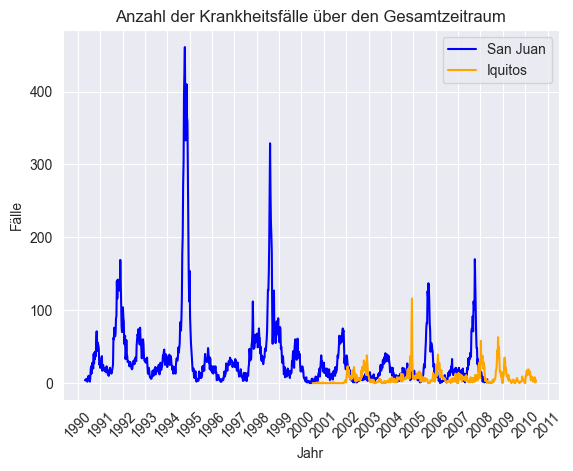

,city,year,weekofyear,week_start_date,total_precip_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,combined_dew_point_humidity,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,station_avg_temp_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_fixed
0,sj,1990,18,1990-04-30,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,25.442857,29.4,20.0,16.0,18
1,sj,1990,19,1990-05-07,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,26.714286,31.7,22.2,8.6,19
2,sj,1990,20,1990-05-14,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,26.714286,32.2,22.8,41.4,20
3,sj,1990,21,1990-05-21,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,27.471429,33.3,23.3,4.0,21
4,sj,1990,22,1990-05-28,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,28.942857,35.0,23.9,5.8,22


In [163]:
df_sj_train['week_start_date'] = pd.to_datetime(df_sj_train['week_start_date'], format='%Y-%m-%d')
df_iq_train['week_start_date'] = pd.to_datetime(df_iq_train['week_start_date'], format='%Y-%m-%d')

fig, ax = plt.subplots()

ax.plot(df_sj_train['week_start_date'], df_sj_labels['total_cases'], label='San Juan', color='blue')
ax.plot(df_iq_train['week_start_date'], df_iq_labels['total_cases'], label='Iquitos', color='orange')

ax.set_title('Anzahl der Krankheitsfälle über den Gesamtzeitraum')
ax.set_xlabel('Jahr')
ax.set_ylabel('Fälle')
ax.legend()

# Setzen Sie die Locator- und Formatter-Objekte für die x-Achse
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Locator für 1-Jahres-Schritte
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formatter für das Anzeigen des Jahres

plt.xticks(rotation=45)  # Optional: Drehen Sie die Jahreszahlen für eine bessere Lesbarkeit

plt.savefig('pictures/total_cases_im_gesamtzeitraum.png', bbox_inches="tight")
plt.show()

### Fehlende Werte
Hier werden fehlende Werte visualisiert.
Man sieht zwei Daten die, außer die NDVI-Attribute, null Werte besitzen. Sie sind mit dem Datum 1992-01-01 und 1998-01-01 gekennzeichnet.
Es gibt eine große Lücke an Werten der NDVI-Attribute von 1994-09-24 bis 1994-12-24

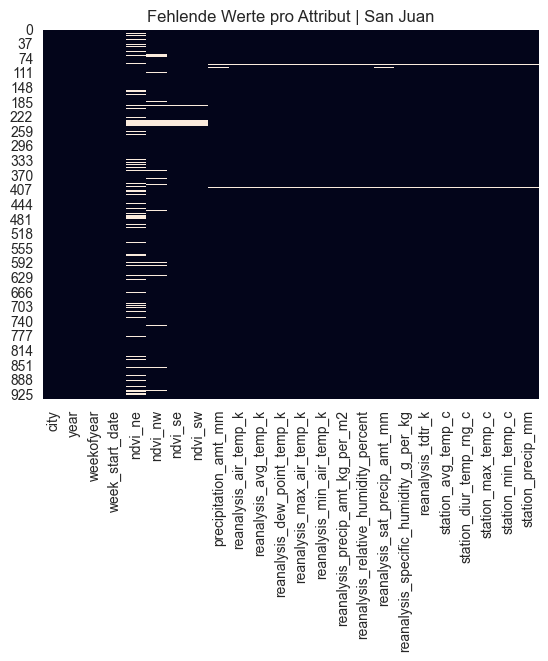

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [143]:
sns.heatmap(df_sj_train.isnull(), cbar=False).set(title='Fehlende Werte pro Attribut | San Juan')
plt.savefig('pictures/null_werte_pro_attribut_sj.png',bbox_inches="tight")
plt.show()

Hier sieht man die Attribute, die am meisten mit null Werten belegt sind. 
Die NDVI-Attribute sind ganz oben, mit 'ndvi_ne' am lückenhaftesten.

In [144]:
def missing_data_percent(df):
    # Verteilung der fehlenden Daten
    null_vals = df.isnull().sum()
    total_vals = len(df)
    null_percent = (null_vals / total_vals) * 100
    df_null_percent = pd.DataFrame({'Attribut': null_vals.index, 'Prozent': null_percent.values})
    barplot = sns.barplot(x='Attribut', y='Prozent', data=df_null_percent)
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.title('Prozentige Verteilung der fehlenden Daten pro Attribut | San Juan')
    plt.savefig('pictures/prozentverteilung_null_werte_sj.png',bbox_inches="tight")
    plt.show()

C:\Users\rener\AppData\Local\Temp\ipykernel_21828\1660113403.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=40, ha="right")


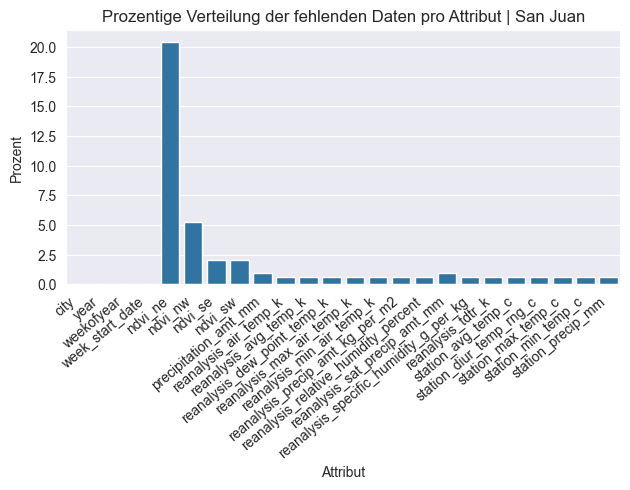

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [145]:
missing_data_percent(df_sj_train)

## Wertebereichverteilung
In welchen Wertebereichen liegen die Werte der Attribute?

In [146]:
def max_min_avg(df):
    # Zeigt Minimum, Maximum und Durchschnitt der Attribute
    result_df = pd.DataFrame({
    'max': df_sj_ignored.max(),
    'min': df_sj_ignored.min(),
    'avg': df_sj_ignored.mean()
    })
    return result_df

In [147]:
max_min_avg(df_sj_ignored)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [148]:
def attribute_distribution_histogram(df,rows,cols):
    # Erstellt Histogramme der Attribute
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.flatten()
    for i, column in enumerate(df.columns):
        sns.histplot(data=df, x=column, kde=True, color="skyblue", ax=axs[i])
    plt.tight_layout()
    plt.savefig('pictures/alle_attribute_',bbox_inches="tight")
    plt.show()

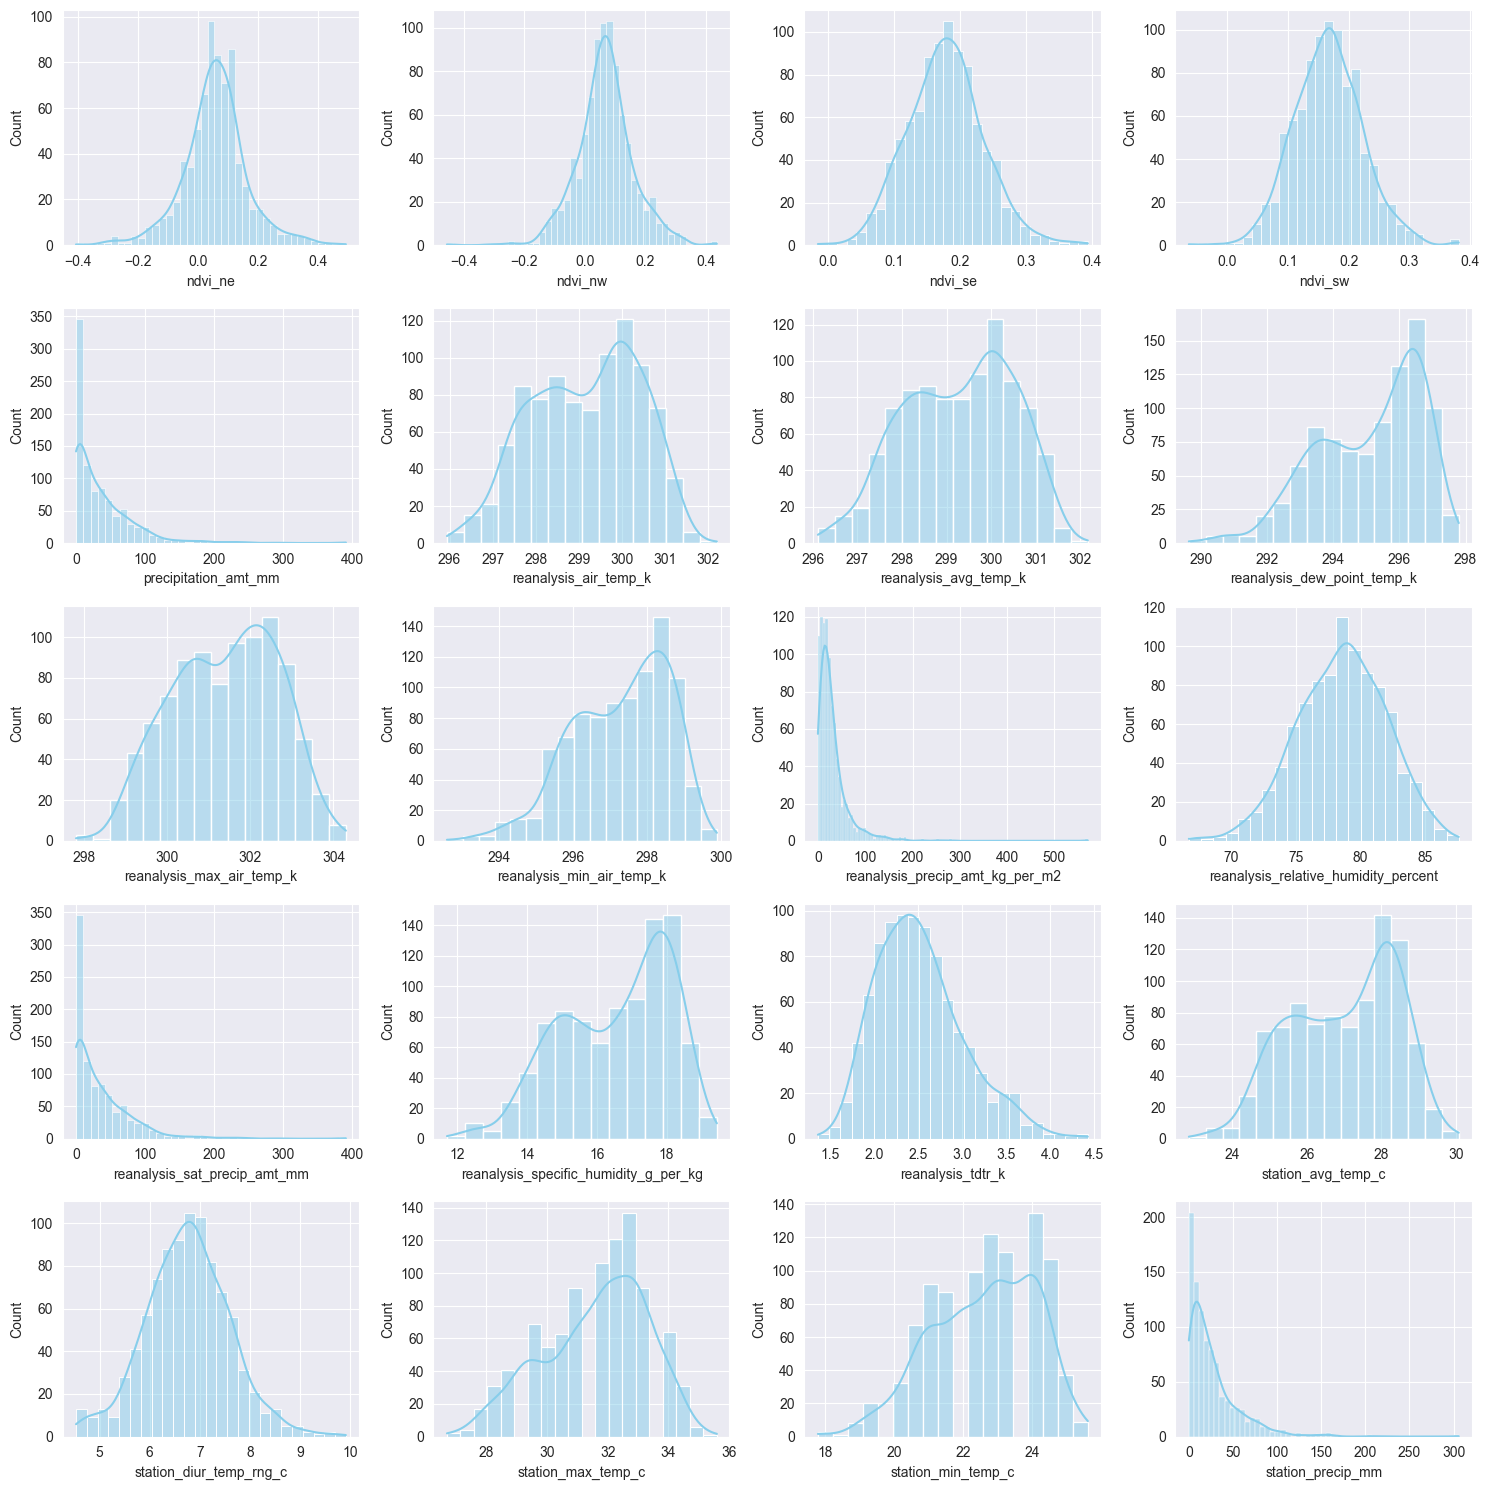

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [149]:
attribute_distribution_histogram(df_sj_ignored,5,4)

### Ausreißer
In sj
wenige Ausreißer bei temperaturbedingten Attributen
mäßige Ausreißer bei Vegetationsdaten
sehr viele Ausreißer bei Niederschlagsdaten

In [150]:
def outlier_boxplot(df):
    # Erstellt Boxplots für jedes Attribut
    num_columns = len(df.columns)
    num_rows = -(-num_columns // 4)
    fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
    axes = axes.flatten()
    for idx, column in enumerate(df.columns):
        sns.boxplot(y=df[column], ax=axes[idx])
        axes[idx].set_title(column)
    for i in range(num_columns, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

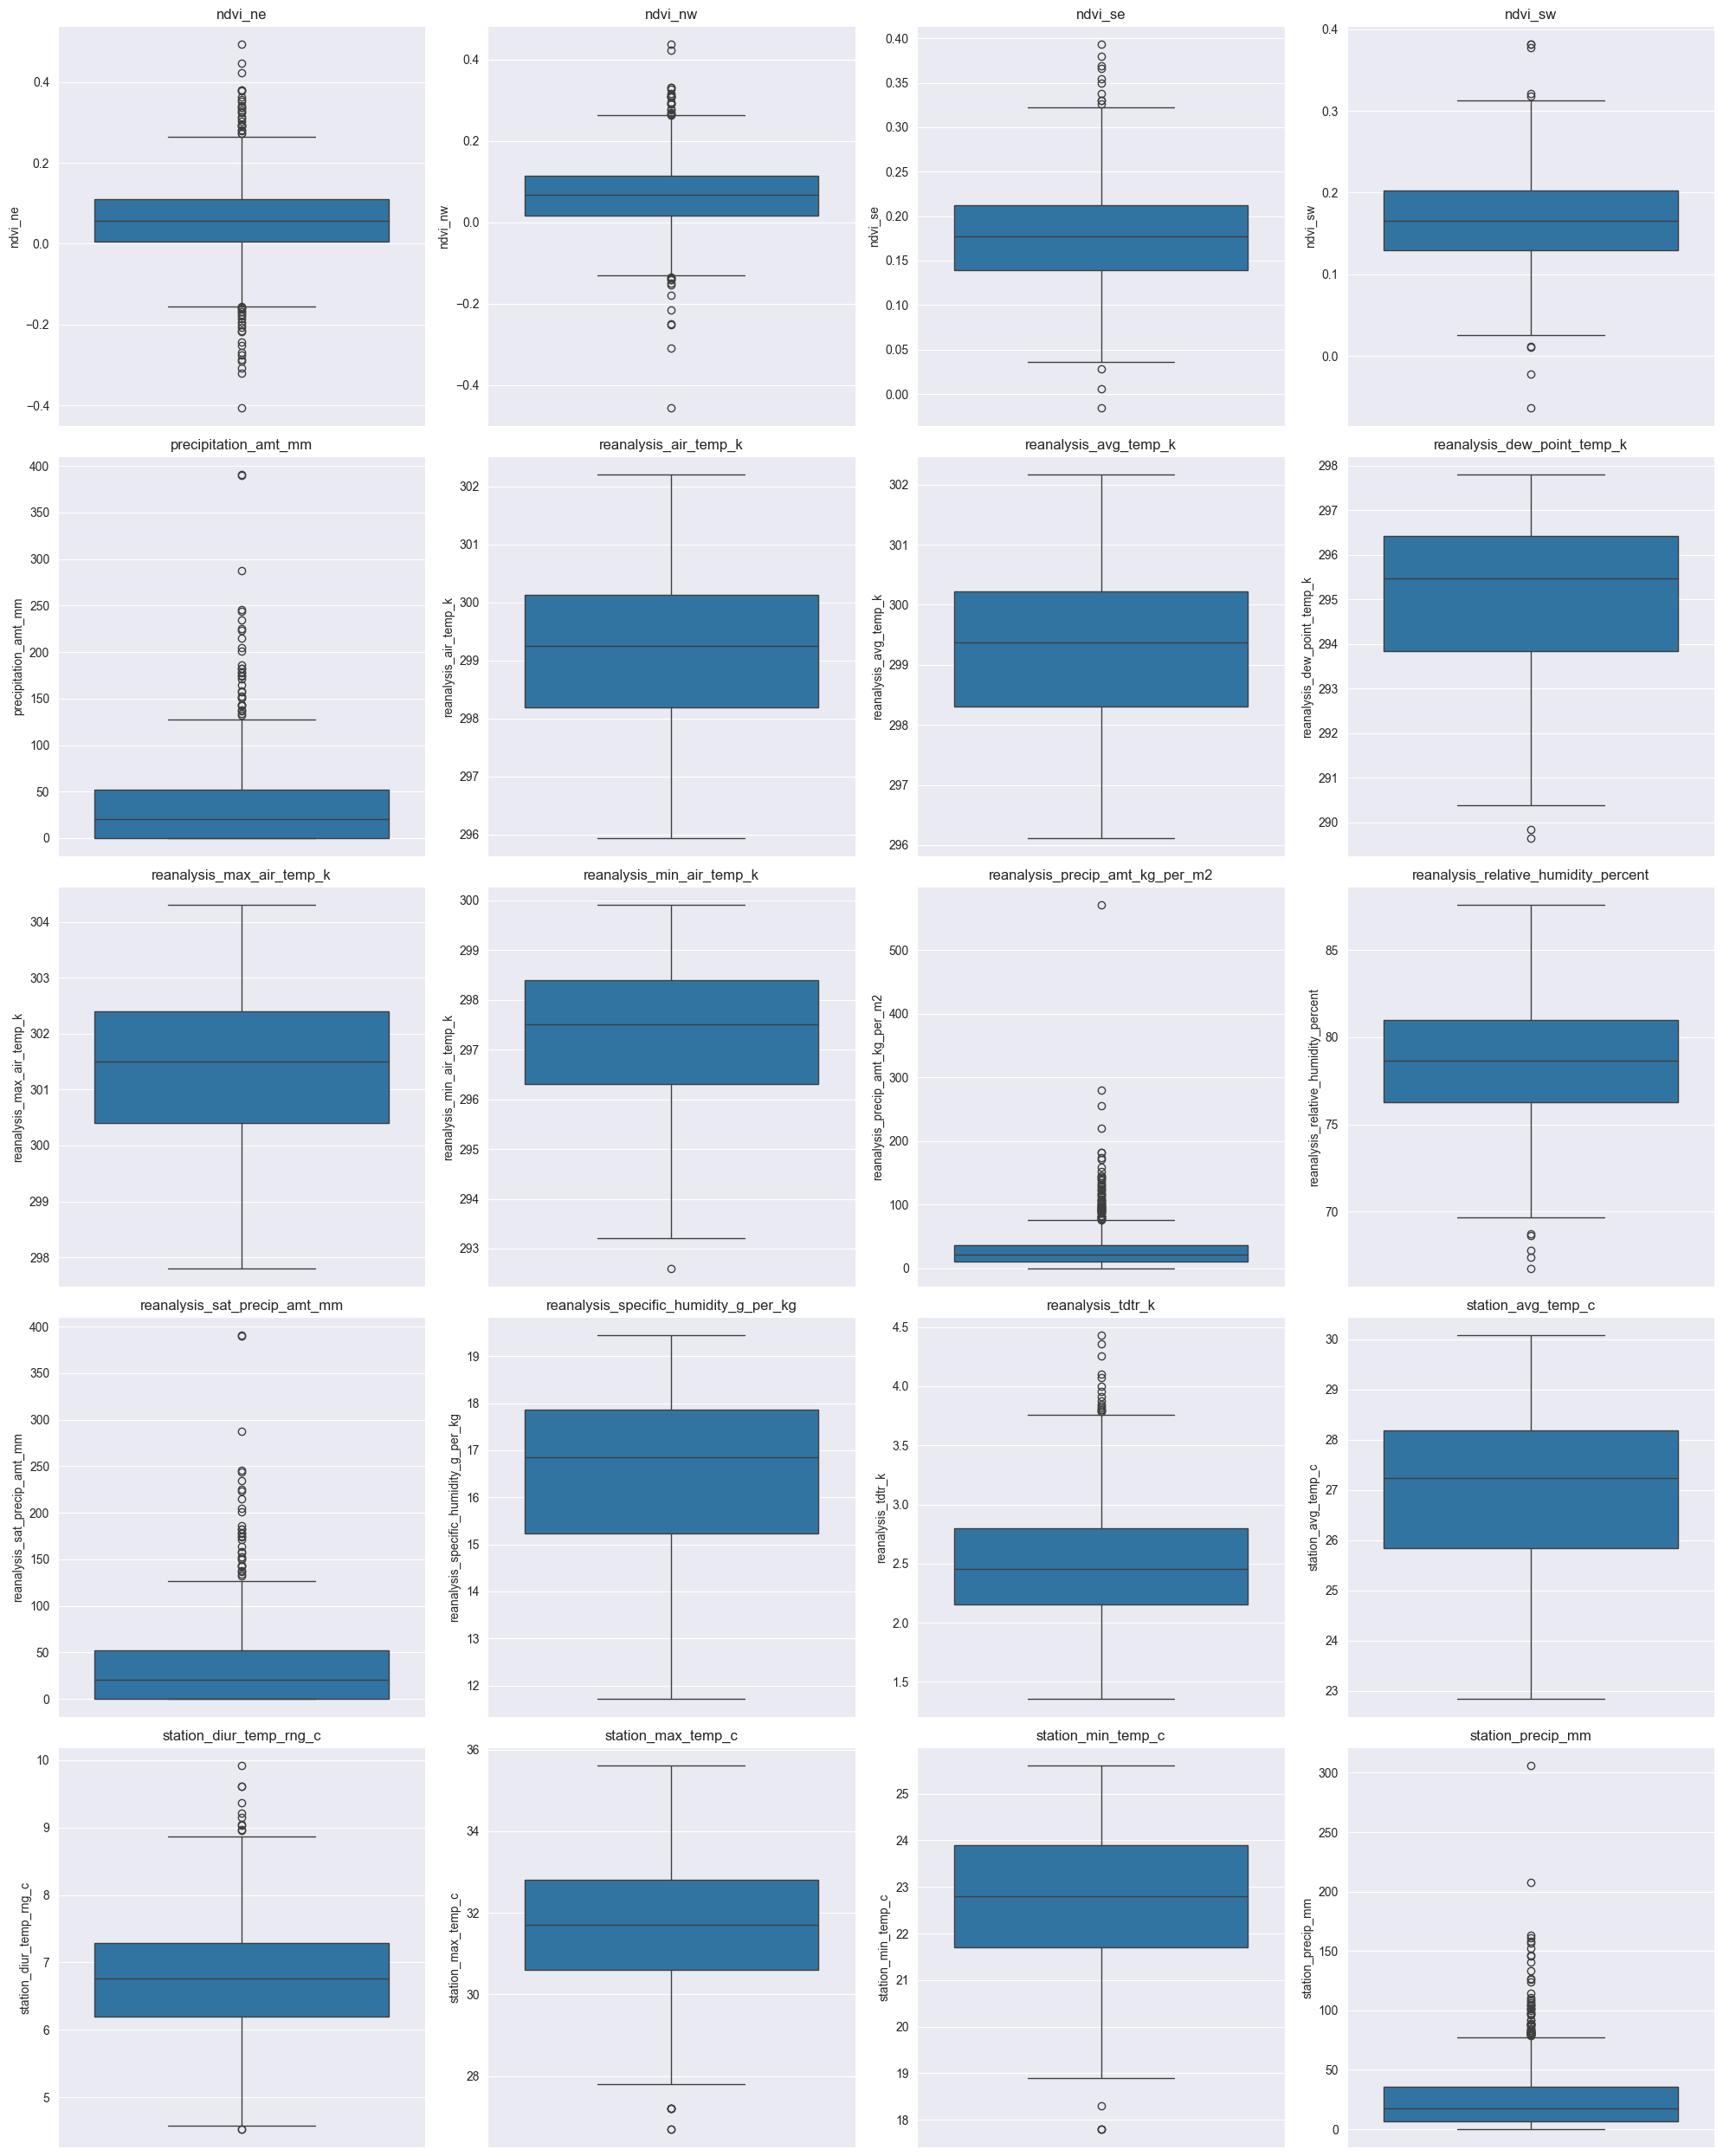

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [151]:
outlier_boxplot(df_sj_ignored)

### Korrelierende Daten

In [152]:
def correlation_matrix(df):
    plt.figure(figsize=[10,10])
    sns.heatmap(df.corr(),square=True, vmin=-1, vmax=1, 
                center=0, cmap='RdBu_r', annot=True)
    plt.show()

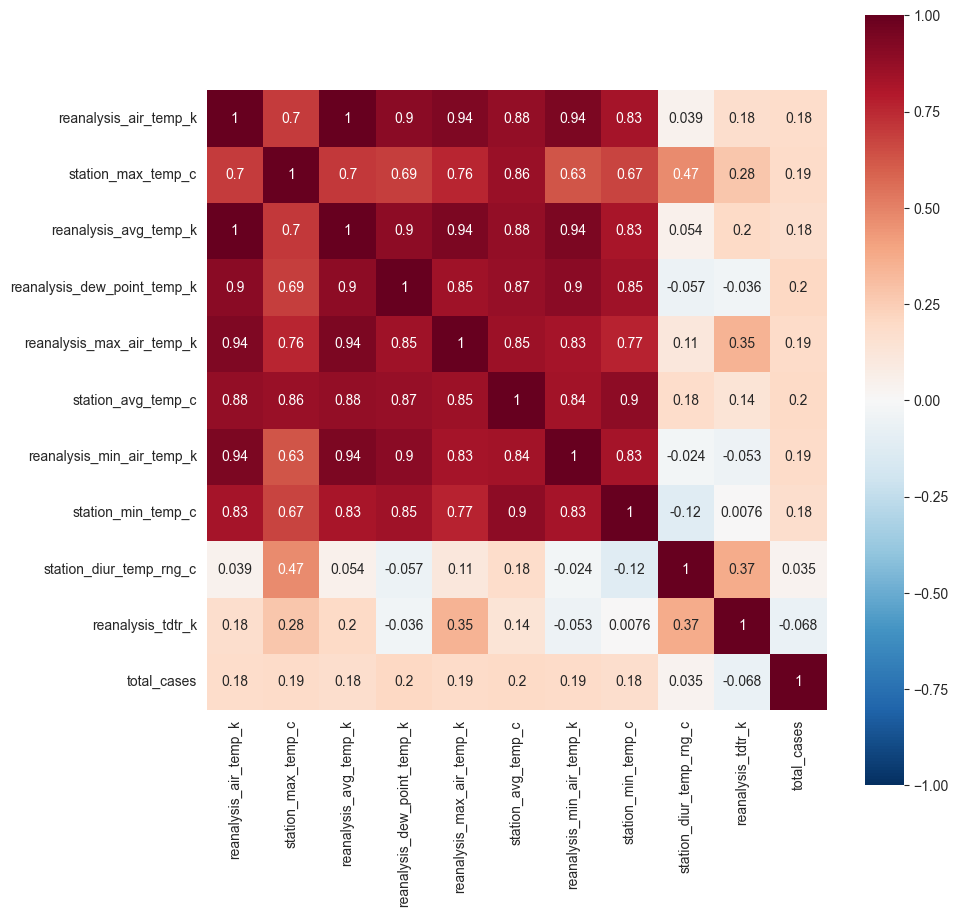

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [153]:
# Temperaturdaten und Zielvariable
temperature = df_sj_train[['reanalysis_air_temp_k',
                           'station_max_temp_c',
                           'reanalysis_avg_temp_k',
                           'reanalysis_dew_point_temp_k',
                           'reanalysis_max_air_temp_k',
                           'station_avg_temp_c',
                           'reanalysis_min_air_temp_k',
                           'station_min_temp_c',
                           'station_diur_temp_rng_c',
                           'reanalysis_tdtr_k',
                           ]].copy()
temperature['total_cases'] = df_sj_labels['total_cases'].copy()
correlation_matrix(temperature)

Die Korrelationsmatrix zeigt, dass die Attribute der Temperaturspannen ('station_diur_temp_rng_c','reanalysis_tdtr_k') nicht mit den Krankheitsfällen korrelieren und werden deswegen für die Weiterverarbeitung nicht benötigt
Weiterhin kann man sehen, dass alle restlichen temperaturbezogenen Attribute (weniger stark 'station_max_temp_c') stark miteinander korrelieren. Demnach können sie normalisiert werden und mit dem gemeinsamen Durchschnitt zu einer Variable zusammengefasst werden. 

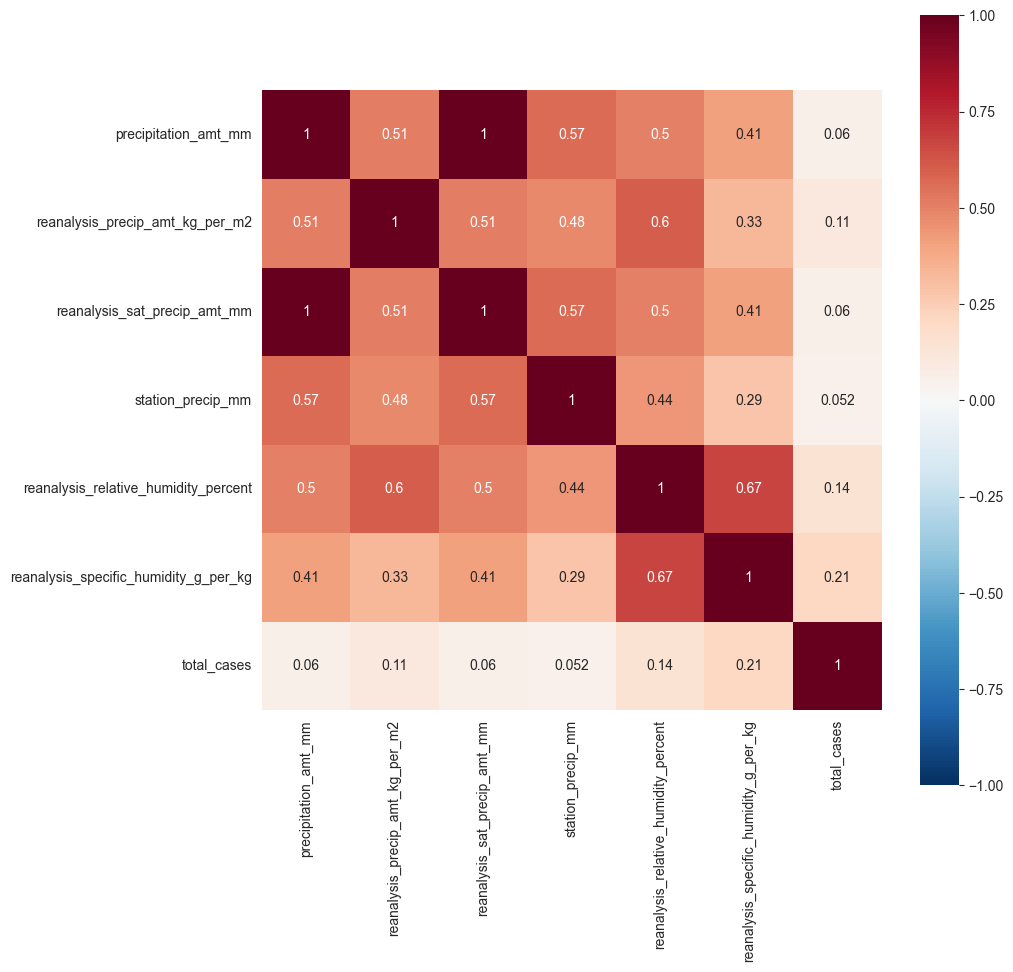

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [154]:
# Niederschlagsdaten und Zielvariable

precipitation = df_sj_train[['precipitation_amt_mm',
                             'reanalysis_precip_amt_kg_per_m2',
                             'reanalysis_sat_precip_amt_mm',
                             'station_precip_mm',
                             'reanalysis_relative_humidity_percent',
                             'reanalysis_specific_humidity_g_per_kg',]].copy()
precipitation['total_cases'] = df_sj_labels['total_cases'].copy()
correlation_matrix(precipitation)

Zu erkennen ist, dass 'precipitation_amt_mm' und 'reanalysis_sat_precip_amt_mm' gleich sind. Dies wird durch einen Blick durch die Daten bestätigt

In [155]:
df_sj_train[['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm']].head()

,precipitation_amt_mm,reanalysis_sat_precip_amt_mm
0,12.42,12.42
1,22.82,22.82
2,34.54,34.54
3,15.36,15.36
4,7.52,7.52


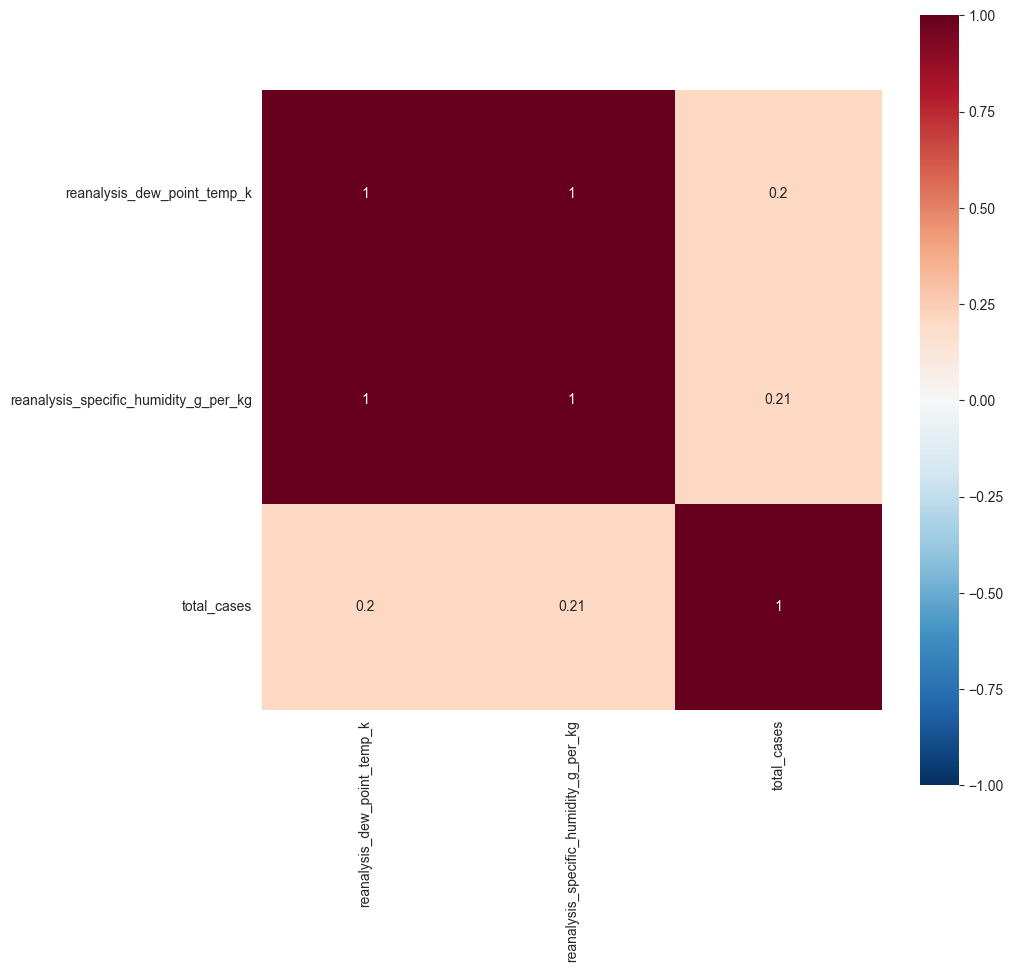

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [156]:
dew_point_humid = df_sj_train[['reanalysis_dew_point_temp_k',
                             'reanalysis_specific_humidity_g_per_kg']].copy()
dew_point_humid['total_cases'] = df_sj_labels['total_cases'].copy()
correlation_matrix(dew_point_humid)

Die beiden Attribute korrelieren stark und haben auch ungefähr den gleichen Einfluss auf die Zielvariable. Sie können standardisiert und zusammengefasst werden

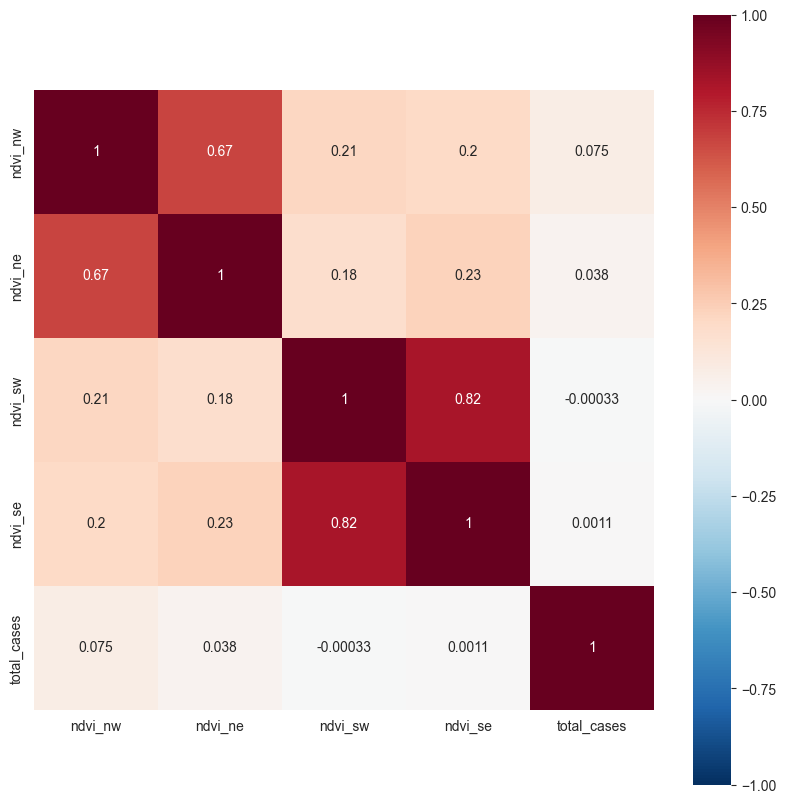

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [157]:
# Vegetationsdaten und Zielvariable

vegetation = df_sj_train[['ndvi_nw','ndvi_ne','ndvi_sw','ndvi_se',]].copy()
vegetation['total_cases'] = df_sj_labels['total_cases'].copy()
correlation_matrix(vegetation)

Die Korrelationsmatrix zeigt, dass die Vegetationsdaten sehr wenig mit den Krankheitsfällen korrelieren.

# Datenpräparation
Welche Daten sollen für das weitere Vorgehen ausgewählt werden?
Welche Daten und Attribute müssen bereinigt werden?
Wie wird mit Ausreißern umgegangen?
Müssen Daten transformiert werden?
Müssen Daten formatiert werden? (Manche wurden schon formatiert: 'week_start_date' wurde von String in Datetime formatiert) 

### Bearbeiten der Attribute
Die im vorherigen Kapitel genannten Attribute werden nun entfernt oder zusammengefasst

In [158]:
df_sj_train.drop(['ndvi_nw','ndvi_ne','ndvi_sw','ndvi_se',
                  'reanalysis_sat_precip_amt_mm',
                  'station_diur_temp_rng_c','reanalysis_tdtr_k',
                  'reanalysis_specific_humidity_g_per_kg'],axis=1,inplace=True)

# precipitation_amt_mm wird umbenannt
df_sj_train = df_sj_train.rename(columns={'precipitation_amt_mm': 'total_precip_mm'})



# 'reanalysis_dew_point_temp_k' wird umbenannt
df_sj_train = df_sj_train.rename(columns={'reanalysis_dew_point_temp_k': 'combined_dew_point_humidity'})

C:\Users\rener\AppData\Local\Temp\ipykernel_21828\2274588341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_train.drop(['ndvi_nw','ndvi_ne','ndvi_sw','ndvi_se',


,city,year,weekofyear,week_start_date,total_precip_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,combined_dew_point_humidity,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,station_avg_temp_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,25.442857,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,26.714286,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,26.714286,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,27.471429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,28.942857,35.0,23.9,5.8


### Normalisierung
Die Temperaturdaten werden normalisiert.

In [166]:
df_temp_cols = df_sj_train[['reanalysis_air_temp_k',
                           'reanalysis_avg_temp_k',
                           'reanalysis_max_air_temp_k',
                           'station_avg_temp_c',
                           'reanalysis_min_air_temp_k',
                           'station_min_temp_c']].copy()
df_norm_temp_cols = pd.DataFrame(MinMaxScaler().fit_transform(df_temp_cols), 
                            columns=df_temp_cols.columns)
df_norm_temp_cols['temp_avg'] = df_norm_temp_cols.mean(axis=1)

,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,station_avg_temp_c,reanalysis_min_air_temp_k,station_min_temp_c
0,0.261008,0.269185,0.307692,0.359684,0.452055,0.282051
1,0.362993,0.384888,0.476923,0.535573,0.520548,0.564103
2,0.454027,0.456907,0.415385,0.535573,0.643836,0.641026
3,0.486881,0.514758,0.553846,0.640316,0.602740,0.705128
4,0.571755,0.586777,0.630769,0.843874,0.671233,0.782051


Die Feuchtigkeitsdaten werden normalisiert 

In [160]:
df_humid_cols = df_sj_train[['combined_dew_point_humidity']].copy()
df_norm_humid_cols = pd.DataFrame(MinMaxScaler().fit_transform(df_temp_cols), 
                            columns=df_temp_cols.columns)

,city,year,weekofyear,week_start_date,total_precip_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,combined_dew_point_humidity,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,station_avg_temp_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,25.442857,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,26.714286,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,26.714286,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,27.471429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,28.942857,35.0,23.9,5.8


### Behandlung von fehlenden Daten
Bei näherer Betrachtung gibt es Jahre mit Woche 53 (z.B. 1993), die immer aus null-Werten bestehen.
Auch ist die Woche 1 des Vorjahres der vorher genannten Jahren null.
Nach Abgleich mit den originellen Daten auf der Website wurde herausgefunden, dass sich die Daten verschoben haben.
Andere Mitbewerber des Wettbewerbs haben verschiedene Lösungsansätze verwendet, unter anderem die Löschung der Daten oder die Imputation anhand der Attribute.
Hier wird der Lösungsansatz des Github Users "conditg" verwendet, welche in der Datei "https://github.com/conditg/deng-ai/blob/master/SanJuan.ipynb" gefunden werden kann.
Die Wochen wurden alle um 1 inkrementiert und die resultierenden Wochen größer als 52 wurden ab Woche 1 begonnen

In [161]:
#Increment all week values by one for all problem years
df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.year==1993,df_sj_train.weekofyear+1, df_sj_train.weekofyear)
for year in [1994,1995,1999,2000,2005,2006]:
    df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.year==year,df_sj_train.weekofyear_fixed+1, df_sj_train.weekofyear_fixed)

#Reduce any week values over 52 down to 1    
df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.weekofyear_fixed>52,1, df_sj_train.weekofyear_fixed)



df_sj_labels.loc[:,'weekofyear_fixed'] = np.where(df_sj_labels.year==2010,
                                              df_sj_labels.weekofyear+1, df_sj_labels.weekofyear) 
for year in [2011,2012]:
    df_sj_labels.loc[:,'weekofyear_fixed'] = np.where(df_sj_labels.year==year,
                                                  df_sj_labels.weekofyear_fixed+1, df_sj_labels.weekofyear_fixed)
df_sj_labels.loc[:,'weekofyear'] = np.where(df_sj_labels.weekofyear_fixed>52,
                                        1, df_sj_labels.weekofyear_fixed)

C:\Users\rener\AppData\Local\Temp\ipykernel_21828\247858975.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_labels.loc[:,'weekofyear_fixed'] = np.where(df_sj_labels.year==2010,
C:\Users\rener\AppData\Local\Temp\ipykernel_21828\247858975.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_labels.loc[:,'weekofyear_fixed'] = np.where(df_sj_labels.year==year,
C:\Users\rener\AppData\Local\Temp\ipykernel_21828\247858975.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,city,year,weekofyear,week_start_date,total_precip_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,combined_dew_point_humidity,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,station_avg_temp_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_fixed
0,sj,1990,18,1990-04-30,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,25.442857,29.4,20.0,16.0,18
1,sj,1990,19,1990-05-07,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,26.714286,31.7,22.2,8.6,19
2,sj,1990,20,1990-05-14,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,26.714286,32.2,22.8,41.4,20
3,sj,1990,21,1990-05-21,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,27.471429,33.3,23.3,4.0,21
4,sj,1990,22,1990-05-28,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,28.942857,35.0,23.9,5.8,22


Aus den Methoden zum Auffüllen von Zeitreihendaten wurde Interpolation ausgewählt


In [162]:
df_sj_train = df_sj_train.interpolate(method='pad')

,city,year,weekofyear,week_start_date,total_precip_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,combined_dew_point_humidity,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,station_avg_temp_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_fixed
0,sj,1990,18,1990-04-30,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,25.442857,29.4,20.0,16.0,18
1,sj,1990,19,1990-05-07,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,26.714286,31.7,22.2,8.6,19
2,sj,1990,20,1990-05-14,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,26.714286,32.2,22.8,41.4,20
3,sj,1990,21,1990-05-21,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,27.471429,33.3,23.3,4.0,21
4,sj,1990,22,1990-05-28,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,28.942857,35.0,23.9,5.8,22


### Saisonaler Aspekt der Zeitreihe
Anhand der Zeitreihendekomposition lassen sich Muster, wie Trend, Saison, etc. erkennen.

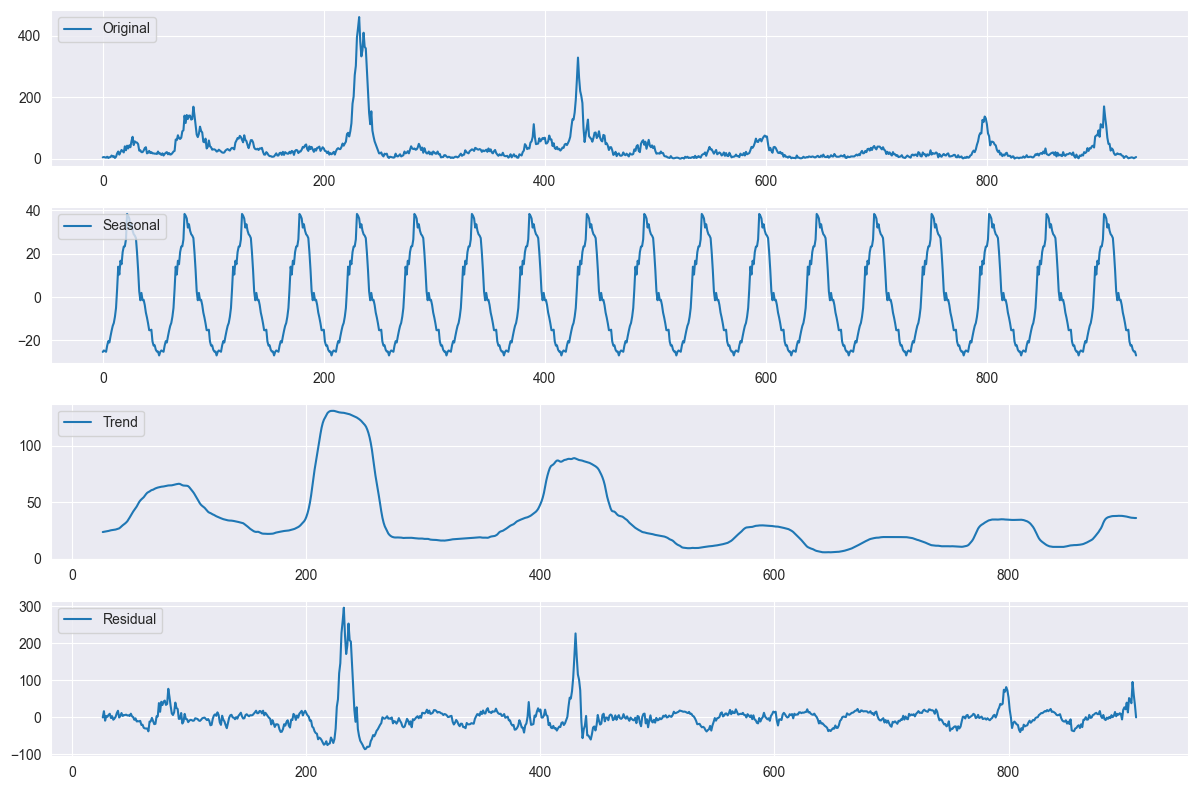

pandas.core.series.Series

In [171]:
df_sj_with_cases = df_sj_train['week_start_date'].copy()
df_sj_with_cases['total_cases'] = df_sj_labels['total_cases'].copy()
result = seasonal_decompose(df_sj_with_cases['total_cases'],period=52)

seasonal = result.seasonal
trend = result.trend
resid = result.resid
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df_sj_with_cases['total_cases'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('pictures/zeitreihe_sj.png',bbox_inches="tight")
plt.show()

Die Saison-Komponente zeigt, dass sich die Höhepunkte regelmäßig wiederholen. Um näheren Einblick zu bekommen können die Wochen jedes Jahres abgebildet werden

In [177]:
df_sj_lineplot = df_sj_train[['weekofyear_fixed','year']].copy()
df_sj_lineplot['total_cases'] = df_sj_labels['total_cases'].copy()

,weekofyear_fixed,year,total_cases
0,18,1990,4
1,19,1990,5
2,20,1990,4
3,21,1990,3
4,22,1990,6


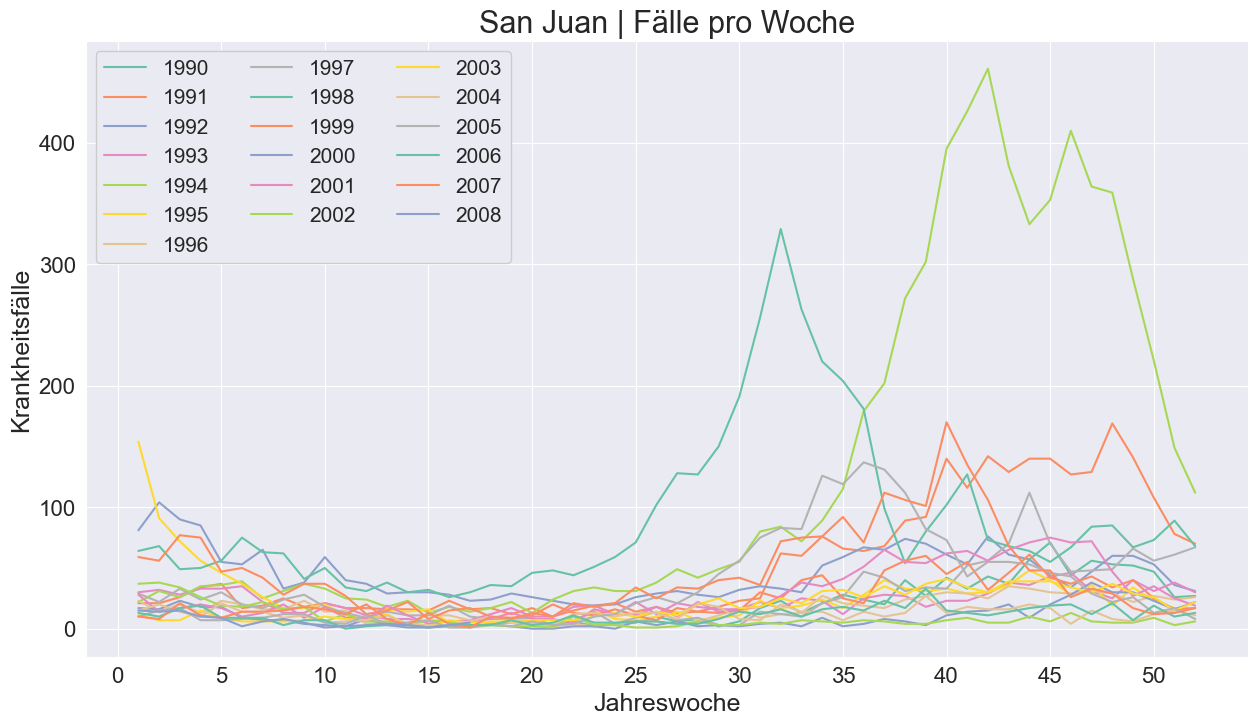

In [182]:
plt.figure(figsize=[15,8])
sns.lineplot(x='weekofyear_fixed',y='total_cases', hue='year',
                data=df_sj_lineplot, palette='Set2',legend='full')
plt.legend(loc=2, framealpha=1, ncol=3, prop={'size': 15})    
plt.ylabel('Krankheitsfälle',size=18)
plt.xlabel('Jahreswoche',size=18)
plt.xticks([0,5,10,15,20,25,30,35,40,45,50], size=16)
plt.yticks(size=16)
plt.title('San Juan | Fälle pro Woche', size=22)
plt.show()

Man kann drei Phasen im Jahr sehen: 
1.  Woche 1-11: Abnehmende Fallanzahl
2.  Woche 12-22: Gleichbleibende Fallanzahl mit Minima
3.  Woche 23-52: stark steigende Fallanzahl mit Maxima
Diese können mithilfe von Feature Engineering mit eigenen Attributen im DataFrame repräsentiert werden. 

# Aufbau des Models
Ein DataFrame mit allen ausgewählten Variablen zur Erstellung des Models wird erstellt.

In [ ]:
df_sj_model_features = df_sj_train[['year','weekofyear_fixed','station_max_temp_c','reanalysis_relative_humidity_percent']].copy() 
df_sj_model_features['total_cases'] = df_sj_labels[['total_cases']].copy()
df_sj_model_features['combined_dew_point_humidity'] = df_norm_humid_cols[['combined_dew_point_humidity']].copy()
df_sj_model_features['temp_avg'] = df_norm_temp_cols[['temp_avg']].copy()
df_sj_model_features['phase1'] = df_sj_train.loc[df_sj_train['weekofyear_fixed'].between(0, 11, inclusive=True), 'weekofyear_fixed']
df_sj_model_features['phase2'] = df_sj_train.loc[df_sj_train['weekofyear_fixed'].between(12, 22, inclusive=True), 'weekofyear_fixed']
df_sj_model_features['phase3'] = df_sj_train.loc[df_sj_train['weekofyear_fixed'].between(23, 52, inclusive=True), 'weekofyear_fixed']